# Twitter Sentiment Analysis

Libraries Installation and Import

In [ ]:
!pip install allennlp
!pip install --upgrade transformers
!pip install --upgrade torchvision
!pip install allennlp
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1
    Uninstalling torchvision-0.13.1:
      Successfully uninstalled torchvision-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 2.1.1 which is incompatible.
allennlp 2.10.1 requires torchvision<0.14.0,>=0.8.1, but you have torchvision 0.16.1 which is incompatible.
allennlp 2.10.1 requires transformers<4.21,>=4.1, b

In [ ]:
import pandas as pd
import keras
import os
import sys
import re
from allennlp.modules.elmo import Elmo, batch_to_ids

import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D
import torch
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback


Dataset Upload

In [ ]:
# the dataset has to be .csv and has to have the same

from google.colab import files
uploaded = files.upload()


Saving dataset (1).csv to dataset (1).csv


In [ ]:
dfData = pd.read_csv(io.BytesIO(uploaded['dataset (1).csv']), encoding='latin-1')
dfData = pd.read_csv('/content/dataset (1).csv', encoding='latin-1')
#dfData= dfData.iloc[:300000]


Balancing the dataset

In [ ]:
# Balancing the data
dfData = dfData[['text', 'target']]

# Balancing the data
positive_samples = dfData[dfData['target'] == 4]
negative_samples = dfData[dfData['target'] == 0]

# Check the number of positive and negative samples
num_positive_samples = len(positive_samples)
num_negative_samples = len(negative_samples)

# Balance the dataset by selecting the same number of samples from the class with fewer instances
min_samples = min(num_positive_samples, num_negative_samples)

balanced_positive_samples = positive_samples.sample(n=min_samples, random_state=42)
balanced_negative_samples = negative_samples.sample(n=min_samples, random_state=42)

# Concatenate the balanced samples to create the final balanced dataset
balanced_df = pd.concat([balanced_positive_samples, balanced_negative_samples])

# Shuffle the dataset to randomize the order
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced dataset
print(balanced_df['target'].value_counts())
print(balanced_df.shape[0])

0    248576
4    248576
Name: target, dtype: int64
497152


Text preprocessing

In [ ]:
#Eliminating all the special characters
def preprocess_tweet(tweet):
    # Remove mentions
    tweet = re.sub(r"@[A-Za-z0-9_]+", "", tweet)
    # Remove hashtags
    tweet = re.sub(r"#", "", tweet)
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    # Remove special characters and numbers
    tweet = re.sub(r"[^A-Za-z]+", " ", tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    return tweet

Text tokenization and pre-trained ELMo model loading & ELMO embeddings creation

In [ ]:
# Tokenize text
def tokenize_text(df, max_tokens):
    df['tokens'] = df['text'].apply(lambda text: text_to_word_sequence(text, lower=False)[:max_tokens])


balanced_df['text'] = balanced_df['text'].apply(preprocess_tweet)

# Encode the target variable if needed
balanced_df['target'] = balanced_df['target'].replace({0: 0, 4: 1})

# Split the dataset into training, testing, and validation sets
train_data, test_data = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Tokenize text
max_tokens = 100
tokenize_text(train_data, max_tokens)
tokenize_text(test_data, max_tokens)



In [ ]:

# Load the pre-trained ELMo model
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

elmo = Elmo(options_file, weight_file, 1, dropout=0)  # Adjust the dropout if needed
elmo.to(torch.device("cuda"))  # Move ELMo to GPU if available

def create_elmo_embeddings(elmo, documents, max_sentences=1000):
    num_sentences = min(max_sentences, len(documents)) if max_sentences > 0 else len(documents)
    print("\n\n:: Lookup of " + str(num_sentences) + " ELMo representations. This takes a while ::")
    embeddings = []
    labels = []

    for i in range(0, num_sentences, 50):  # Batch size of 50 to avoid GPU memory issues
        batch_documents = documents[i:i+50]
        batch_tokens = [document['tokens'] for _, document in batch_documents.iterrows()]  # Access tokens using iterrows()

        character_ids = batch_to_ids(batch_tokens).to(torch.device("cuda"))
        elmo_embedding = elmo(character_ids)
        avg_elmo_embedding = torch.mean(elmo_embedding['elmo_representations'][0], dim=1).detach().cpu().numpy()

        embeddings.extend(avg_elmo_embedding)
        labels.extend([document['target'] for _, document in batch_documents.iterrows()])

        # Some progress info
        percent = 100.0 * (i + 50) / num_sentences
        line = '[{0}{1}]'.format('=' * int(percent / 2), ' ' * (50 - int(percent / 2)))
        status = '\r{0:3.0f}%{1} {2:3d}/{3:3d} sentences'
        sys.stdout.write(status.format(percent, line, i + 50, num_sentences))

        if max_sentences > 0 and i + 50 >= max_sentences:
            break

    return embeddings, labels

# Lookup the ELMo embeddings for all documents in the dataset
train_x, train_y = create_elmo_embeddings(elmo, train_data, max_sentences=-1)
test_x, test_y = create_elmo_embeddings(elmo, test_data, max_sentences=-1)


# Reshape input data
train_x = np.array(train_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
test_y = np.array(test_y)




Output()

Output()



:: Lookup of 397721 ELMo representations. This takes a while ::
100%[==================================================] 397750/397721 sentences

:: Lookup of 99431 ELMo representations. This takes a while ::
100%[==================================================] 99450/99431 sentences

Create ELMO embeddings to be given afterwart to the NN as an input

In [ ]:
# max_tokens is the correct maximum number of tokens
max_tokens = 100

# Ensure that each input sequence has the correct length
train_x_padded = np.array([np.pad(sequence, ((0, max_tokens - len(sequence)), (0, 0)), mode='constant')[:max_tokens] if len(sequence) < max_tokens else sequence[:max_tokens] for sequence in train_x])
test_x_padded = np.array([np.pad(sequence, ((0, max_tokens - len(sequence)), (0, 0)), mode='constant')[:max_tokens] if len(sequence) < max_tokens else sequence[:max_tokens] for sequence in test_x])



In [ ]:

# Create the model
model = Sequential()
model.add(Conv1D(filters=250, kernel_size=3, padding='same', input_shape=(max_tokens, 1)))  # Adjust input shape
model.add(GlobalMaxPooling1D())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



In [ ]:

# Set the learning rate
chosen_lr = 0.001  # Replace with your chosen learning rate

# Update the learning rate in the optimizer
new_optimizer = Adam(learning_rate=chosen_lr)

# Compile the model with the new optimizer
model.compile(loss='binary_crossentropy', optimizer=new_optimizer, metrics=['accuracy'])

Model Training

In [ ]:


# Initialize lists to store metrics for each epoch
train_loss_values, train_accuracy_values = [], []
test_loss_values, test_accuracy_values = [], []
train_f1_values, train_precision_values, train_recall_values = [], [], []
test_f1_values, test_precision_values, test_recall_values = [], [], []
epochs = range(1,21)  #  20 epochs

# Train the model and track metrics across epochs
for epoch in epochs:
    history = model.fit(train_x_padded, train_y, validation_data=(test_x_padded, test_y), epochs=1, batch_size=32, verbose=0)

    # Extract metrics from the training history
    train_loss_values.append(history.history['loss'][0])
    train_accuracy_values.append(history.history['accuracy'][0])

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_x_padded, test_y, verbose=0)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    # Compute F1-score, precision, and recall for training set
    train_predictions = model.predict(train_x_padded)
    train_predictions_binary = (train_predictions > 0.5).astype(int)
    train_f1 = f1_score(train_y, train_predictions_binary)
    train_precision = precision_score(train_y, train_predictions_binary)
    train_recall = recall_score(train_y, train_predictions_binary)

    # Append values to lists
    train_f1_values.append(train_f1)
    train_precision_values.append(train_precision)
    train_recall_values.append(train_recall)

    # Compute F1-score, precision, and recall for test set
    test_predictions = model.predict(test_x_padded)
    test_predictions_binary = (test_predictions > 0.5).astype(int)
    test_f1 = f1_score(test_y, test_predictions_binary)
    test_precision = precision_score(test_y, test_predictions_binary)
    test_recall = recall_score(test_y, test_predictions_binary)

    # Append values to lists
    test_f1_values.append(test_f1)
    test_precision_values.append(test_precision)
    test_recall_values.append(test_recall)

    # Print metrics for each epoch
    print(f"Epoch {epoch}/{len(epochs)} - "
          f"Train Loss: {train_loss_values[-1]:.4f}, "
          f"Train Accuracy: {train_accuracy_values[-1]:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}, "
          f"Train F1: {train_f1:.4f}, "
          f"Train Precision: {train_precision:.4f}, "
          f"Train Recall: {train_recall:.4f}, "
          f"Test F1: {test_f1:.4f}, "
          f"Test Precision: {test_precision:.4f}, "
          f"Test Recall: {test_recall:.4f}")



3108/3108 [==============================] - 5s 1ms/step
Epoch 1/20 - Train Loss: 0.6852, Train Accuracy: 0.5500, Test Loss: 0.6833, Test Accuracy: 0.5534, Train F1: 0.6190, Train Precision: 0.5435, Train Recall: 0.7188, Test F1: 0.6151, Test Precision: 0.5384, Test Recall: 0.7172
3108/3108 [==============================] - 5s 1ms/step
Epoch 2/20 - Train Loss: 0.6825, Train Accuracy: 0.5577, Test Loss: 0.6828, Test Accuracy: 0.5561, Train F1: 0.4706, Train Precision: 0.5855, Train Recall: 0.3933, Test F1: 0.4694, Test Precision: 0.5792, Test Recall: 0.3946
3108/3108 [==============================] - 5s 1ms/step
Epoch 3/20 - Train Loss: 0.6814, Train Accuracy: 0.5604, Test Loss: 0.6805, Test Accuracy: 0.5634, Train F1: 0.5779, Train Precision: 0.5625, Train Recall: 0.5941, Test F1: 0.5752, Test Precision: 0.5575, Test Recall: 0.5941
3108/3108 [==============================] - 4s 1ms/step
Epoch 4/20 - Train Loss: 0.6808, Train Accuracy: 0.5621, Test Loss: 0.6812, Test Accuracy: 0.5641

Metrics Calculation and plot

In [ ]:
# Calculate and print the average metrics
avg_train_loss = sum(train_loss_values) / len(train_loss_values)
avg_train_accuracy = sum(train_accuracy_values) / len(train_accuracy_values)
avg_test_loss = sum(test_loss_values) / len(test_loss_values)
avg_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)

print("\nAverage Metrics Across Epochs:")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Average Test Accuracy: {avg_test_accuracy:.4f}")



Average Metrics Across Epochs:
Average Train Loss: 0.6787
Average Train Accuracy: 0.5663
Average Test Loss: 0.6794
Average Test Accuracy: 0.5648


In [ ]:


# Print the final training loss and accuracy
train_loss, train_accuracy = model.evaluate(train_x_padded[..., np.newaxis], train_y, verbose=0)
test_loss, test_accuracy = model.evaluate(test_x_padded[..., np.newaxis], test_y, verbose=0)

print(f"\nFinal Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

# Use the trained model to make predictions
train_predictions = model.predict(train_x_padded[..., np.newaxis])
test_predictions = model.predict(test_x_padded[..., np.newaxis])

# Convert predictions to binary labels
train_predictions = (train_predictions > 0.5).astype(int)
test_predictions = (test_predictions > 0.5).astype(int)

# Print classification reports for train and test
print("\nTraining Classification Report:")
print(classification_report(train_y, train_predictions))

print("\nTesting Classification Report:")
print(classification_report(test_y, test_predictions))


Final Training Loss: 0.6783, Accuracy: 0.5656
3108/3108 [==============================] - 5s 1ms/step

Training Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59    198620
           1       0.58      0.50      0.53    199101

    accuracy                           0.57    397721
   macro avg       0.57      0.57      0.56    397721
weighted avg       0.57      0.57      0.56    397721


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59     49956
           1       0.57      0.49      0.53     49475

    accuracy                           0.56     99431
   macro avg       0.56      0.56      0.56     99431
weighted avg       0.56      0.56      0.56     99431



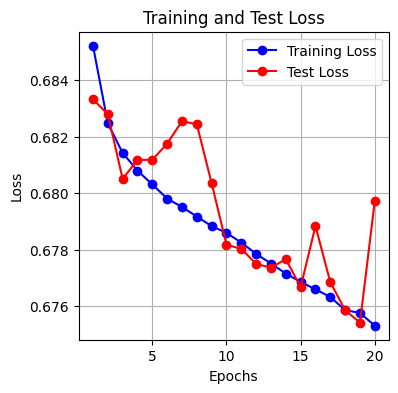

In [ ]:
# Plotting the evolution of metrics


# Plotting loss values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_loss_values, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss_values, 'ro-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

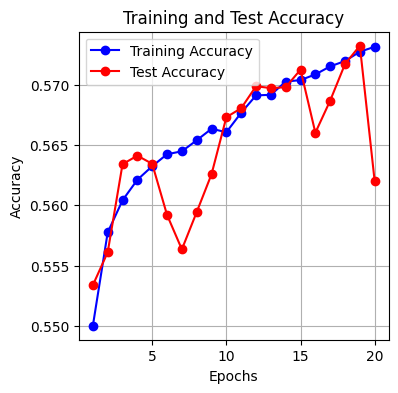

In [ ]:

# Plotting accuracy values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_accuracy_values, 'bo-', label='Training Accuracy')
plt.plot(epochs, test_accuracy_values, 'ro-', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

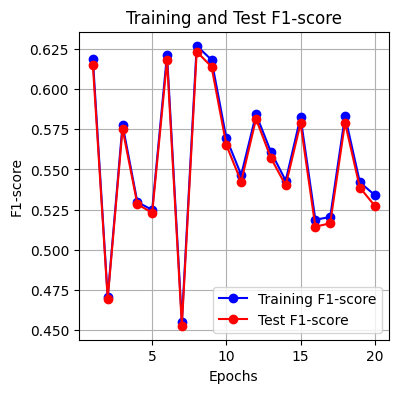

In [ ]:
# Plotting F1-score values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_f1_values, 'bo-', label='Training F1-score')
plt.plot(epochs, test_f1_values, 'ro-', label='Test F1-score')
plt.title('Training and Test F1-score')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()

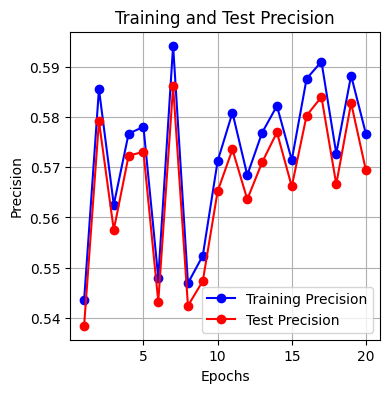

In [ ]:
# Plotting Precision values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_precision_values, 'bo-', label='Training Precision')
plt.plot(epochs, test_precision_values, 'ro-', label='Test Precision')
plt.title('Training and Test Precision')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()


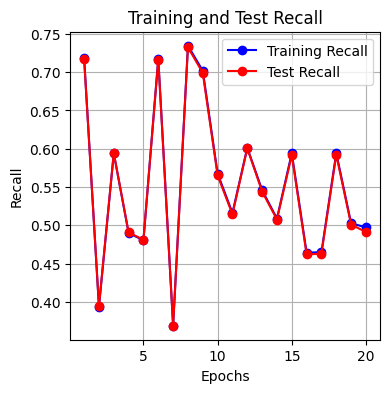

In [ ]:

# Plotting Recall values
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_recall_values, 'bo-', label='Training Recall')
plt.plot(epochs, test_recall_values, 'ro-', label='Test Recall')
plt.title('Training and Test Recall')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

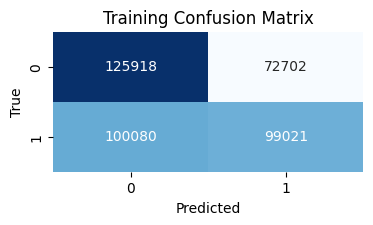

In [ ]:
# Plotting confusion matrix
plt.figure(figsize=(4, 4))

plt.subplot(2, 1, 1)
conf_matrix_train = confusion_matrix(train_y, train_predictions)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

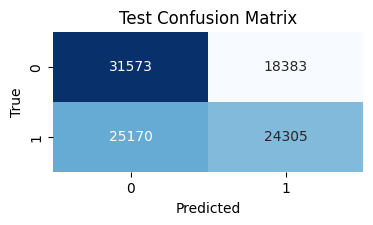

In [ ]:
plt.figure(figsize=(4, 4))
plt.subplot(2, 1, 2)
conf_matrix_test = confusion_matrix(test_y, test_predictions)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')


plt.show()